# Collaborative Filtering of Movies
## MSDS 7349 - Section 401
## Project 3

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Import Dataset](#Import)
* [Business Understanding](#Business-Understanding)
* [Data Understanding](#Data-Understanding)
* [Modeling and Evaluation](#Modeling-and-Evaluation)
* [Deployment](#Deployment)
* [Exceptional Work](#Exceptional-Work)
* [References](#References)

# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)
* [Kevin Cannon](https://github.com/kcannon2)
* [Ernesto Carrera Ruvalcaba](https://github.com/ecarrerasmu)
* [Adam Tschannen](https://github.com/adamtschannen)

# <a name="Import"></a>Import Dataset

In [1]:
%%capture
# Source:
# https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
# Supress output - https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
import graphlab as gl;

filepath = '../data/ml-latest-small/ratings.csv';
ratings = gl.SFrame.read_csv(filepath, column_type_hints = {"rating":int});
movies = gl.SFrame.read_csv('../data/ml-latest-small/movies.csv');
data = ratings.join(movies, on = 'movieId', how = 'left');


#data.show()

# <a name="Business-Understanding"></a>Business Understanding
*[10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

![xkcd: Machine Learning](../images/machine_learning.png)

* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)

> GroupLens is a research lab based out of the University of Minnesota's Department of Computer Science and Engineering. Part of the research lab's focus is in recommender systems. Consequently, GroupLens Research has collected this movie data because they offer a movie recommendation service while providing providing open-source data to the public for free. This dataset was found by our team in a Github Repository compiling publicly available datasets for recommender systems and machine learning. Afterwards we realized the very same dataset is endorsed in the syllabus as a good dataset to use for project 3. At first glance the data looked clean, offered variable sizing depending on the scope of the project, so we decided to proceed with utilizing GroupLens' data. 

* How will you measure the effectiveness of a good algorithm?

> The effectiveness of a good algorithm produced by this project will be measured with cross validation and evaluated in three ways; with Root Mean Squared Error (RMSE), per-user-recall, and per-user-precision.

> The first step in evaluating our algorithm via RMSE will be to calculate the average RMSE of every entry in the dataset using the following equation:

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

> Afterwards, the RMSE for each user in the dataset will be calculated via:

$$\underbrace{RMSE(U)}_{\text{user=U}}=\sqrt{\frac{1}{|U|}\sum_{u\in U} (\hat{y}_u-y_u)^2}$$

> Additionally, the RMSE for each movie in the dataset will be calculated via:

$$\underbrace{RMSE(M)}_{\text{movie=M}}=\sqrt{\frac{1}{|M|}\sum_{m\in M} (\hat{y}_m-y_m)^2}$$

> The per-user-recall will be measured with the following equation:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

> Wherein $p_k$ is a vector of the $k$ highest ranked recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

> The per-user-precision will be measured with the following equation:

$$P(k)=\frac{|a \cap p_k|}{k} $$

> Wherein $p_k$ is a vector of the $k$ recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

* Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

> Potential vehicles in which to validate a given model are A/B testing, Root Mean Squared Error, recall, and precision. A/B testing is not feasible for this project because there is no way to test the model in a live setting. In other words, statistical hypothesis testing via click-rate and response rate cannot be measured in a real-word system because we are not privy to such an application. Fortunately, A/B testing is not the only way to evaluate a recommender system's quality.

> Root Mean Squared Error is one of the most commonly used methods to evaluate a recommender system. RMSE makes sense for the GroupLens movie ratings data because it was specifically collected with recommender systems in mind. In other words, the predicted movie recommendations will be compared to the actual movie recommendations. The GroupLens data even contains their own file of compiled recommendations with which one can carry out comparisons. By measuring general, per-user, and per-movie RMSE we will be able to discern the quality of a given model on a more granular level. Moreover, visualizing the array of averages produced by per-user and per-movie RMSE will provide a general macro overview of a given model. Additionally, statistical tests will be performed to comparatively evaluate models based on their respect RMSE values.

> Recall evaluation does have some limitations as not every user is going to rate all movies they watch. Most likely, users will only rate movies for which they have strong positive or negative feelings. However, per-user-recall is still relevant to the stakeholders needs as it us to answer the following question of interest: "of all the items rated positively by the user, how many did your recommender find?"

> By the same token, the limitations of precision evaluation are the same as those of recall evaluation. Fortunately, per-user-precision still makes sense for validating models for this specific dataset, and is still relevant to the stakeholders needs, because it allows us to answer the following question of interest:"of the k items found by your recommender, how many were rated positively by the user?"

> Much like per-user RMSE, statistical hypothesis tests will be used to for both recall and precision evaluation to comparatively discern the best performing models produced by in this project.

# <a name="Data-Understanding"></a>Data Understanding
*[10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems?*

>"This dataset (ml-20m) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

>Users were selected at random for inclusion and IDS have anonumized. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided."

>The Movie IDs all contain "at least one rating or tag are included in the dataset."

>The generes of movie are: Action,	Animation,	Comedy,	Drama,	Documentary, and	Romance	Short.

In [2]:
movies.head()

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
movies.shape

(9125, 3)

*[10 points] Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.*

In [3]:
# Ernesto insert work here

### Visualizing important attributes

> The command "show" in Turi (excecuted below) automatically generates a graphical interface to visualize the data in an independent window browser. It is divided into 3 sections: "Summary", "Table", and "Plots". The "Summary" section shows the basic statistics of the variable. For the numeric variables, it creates box-whisker plots whereas for the categorical variables it generates a horizontal histogram displaying the label of the most frequent items. The "Table" part allows the user to easily navigate through the records of the dataset. Lastly, the component "Plots" enables the analysis of the relationship between 2 variables by generating customized charts. The user can plot the 2 variables using box-whisker, line chart, and a heat map.

>Looking into the first section "Summary", the description of the 6 variables in the dataset is as follows:

>1) userID: There are 669 unique users in our dataset. The total number of records is 100,004.

>2) movieID: The number of distinct movies is of 9,061.

>3) rating: This variable only takes 6 values, the integers from 0 to 5. The higher the rating the better the movie.

>4) timestamp: The different values for the dates is of 77,900.

>5) Title: There are 9,065 different titles in the dataset. The top 3 of the movies with the highest number of ratings are Forrest Gump, Pulp Fiction, and Shawshank.

>6) Genre: The movies can fall into different ranges. For example, a movie can be categorized as "Comedy and Romance". 

>The top 3 most frequent genres are: "Drama", "Comedy", and "Comedy & Romance". The total number of different combinations of genres is 904.

>Lastly, in section "Plots", the distribution of the rating indicates that the ratings are primarily concentrated in the grades of "3" and "4" and less concentrated in values of "0"

In [4]:
data.show()

Canvas is accessible via web browser at the URL: http://localhost:56115/index.html
Opening Canvas in default web browser.


In [6]:
data.shape

(100004, 6)

# <a name="Modeling-and-Evaluation"></a>Modeling and Evaluation
*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by:*

## [10 Points] Train and adjust parameters

# User-Item Recommendation System

In [22]:
data.head()

userId,movieId,rating,timestamp,title,genres
1,31,2,1260759144,Dangerous Minds (1995),Drama
1,1029,3,1260759179,Dumbo (1941),Animation|Children|Drama|Musical ...
1,1061,3,1260759182,Sleepers (1996),Thriller
1,1129,2,1260759185,Escape from New York(1981) ...,Action|Adventure|Sci-Fi|Thriller ...
1,1172,4,1260759205,Cinema Paradiso (Nuovocinema Paradiso) (1989) ...,Drama
1,1263,2,1260759151,"Deer Hunter, The (1978)",Drama|War
1,1287,2,1260759187,Ben-Hur (1959),Action|Adventure|Drama
1,1293,2,1260759148,Gandhi (1982),Drama
1,1339,3,1260759125,Dracula (Bram Stoker'sDracula) (1992) ...,Fantasy|Horror|Romance|Thriller ...
1,1343,2,1260759131,Cape Fear (1991),Thriller


In [36]:
import graphlab as gl
model = gl.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 100004 observations with 671 users and 9066 items.

Data prepared in: 0.183975s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12500 / 100004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 10                | Not Viable                               |

| 1       | 2.5               | Not Viable                               |

| 2       | 0.625             | Not Viable                               |

| 3       | 0.15625           | Not Viable                               |

| 4       | 0.0390625         | 1.066                                    |

| 5       | 0.0195312         | 1.4193                                   |

| 6       | 0.00976562        | 1.74994                                  |

| 7       | 0.00488281        | 1.93777                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0390625         | 1.066                                    |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 120us        | 2.37636           | 1.10091               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 183.656ms    | 1.71485           | 1.02019               | 0.0390625   |

| 2       | 348.25ms     | 1.33945           | 0.908423              | 0.0390625   |

| 3       | 512.475ms    | 1.11711           | 0.839472              | 0.0390625   |

| 4       | 686.067ms    | 0.957126          | 0.785304              | 0.0390625   |

| 5       | 868.492ms    | 0.840664          | 0.743189              | 0.0390625   |

| 6       | 1.01s        | 0.75085           | 0.707716              | 0.0390625   |

| 10      | 1.60s        | 0.544752          | 0.613508              | 0.0390625   |

| 11      | 1.76s        | 0.514044          | 0.597334              | 0.0390625   |

| 20      | 3.14s        | 0.36177           | 0.509539              | 0.0390625   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.299685

Final training RMSE: 0.461366

In [37]:
results # the recommendation output

userId,movieId,score,rank
1,1234,4.02327537004,1
1,3676,3.79706262637,2
1,237,3.79171109644,3
1,1230,3.78317217741,4
1,440,3.75343247715,5
2,3000,4.08505252216,1
2,2959,4.05042263333,2
2,293,3.97068118516,3
2,1884,3.92725055877,4
2,5618,3.92691790525,5


In [39]:
data.head()

userId,movieId,rating,timestamp,title,genres
1,31,2,1260759144,Dangerous Minds (1995),Drama
1,1029,3,1260759179,Dumbo (1941),Animation|Children|Drama|Musical ...
1,1061,3,1260759182,Sleepers (1996),Thriller
1,1129,2,1260759185,Escape from New York(1981) ...,Action|Adventure|Sci-Fi|Thriller ...
1,1172,4,1260759205,Cinema Paradiso (Nuovocinema Paradiso) (1989) ...,Drama
1,1263,2,1260759151,"Deer Hunter, The (1978)",Drama|War
1,1287,2,1260759187,Ben-Hur (1959),Action|Adventure|Drama
1,1293,2,1260759148,Gandhi (1982),Drama
1,1339,3,1260759125,Dracula (Bram Stoker'sDracula) (1992) ...,Fantasy|Horror|Romance|Thriller ...
1,1343,2,1260759131,Cape Fear (1991),Thriller


## Item-Item Recommendation System

In [41]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp, title, genres;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 100004 observations with 671 users and 9066 items.

Data prepared in: 0.107464s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.049ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 181.06ms                            | 0                | 8               |

| 468.445ms                           | 100              | 9066            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.486023s

movieId,similar,score,rank
31,204,0.387302935123,1
31,185,0.354919135571,2
31,165,0.34523910284,3
1029,1022,0.618203341961,1
1029,2078,0.57891780138,2
1029,594,0.550958395004,3
1061,802,0.402871489525,1
1061,832,0.393596768379,2
1061,2231,0.380867183208,3
1129,2009,0.466705262661,1


In [6]:
train, test = gl.recommender.util.random_split_by_user(data,
                                                    user_id="userId", item_id="movieId",
                                                    max_num_users=100, item_test_proportion=0.2, random_seed=1)

In [43]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp, title, genres;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 97258 observations with 671 users and 8954 items.

Data prepared in: 0.101406s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.896ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 170.174ms                           | 0                | 0               |

| 465.067ms                           | 100              | 8954            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.473684s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0287627373878 |
|   2    |     0.365      | 0.0502992255511 |
|   3    |      0.36      | 0.0715470461441 |
|   4    |      0.33      | 0.0907199336296 |
|   5    |     0.312      |  0.105341621496 |
|   6    | 0.286666666667 |  0.114775620101 |
|   7    | 0.268571428571 |  0.122780719974 |
|   8    |    0.26625     |  0.137868488726 |
|   9    |      0.26      |  0.144932939148 |
|   10   |     0.253      |  0.15445766519  |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5268356362641526)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  310   |   2   | 1.52495791659 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)

In [44]:
print rmse_results.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])


In [45]:
rmse_results['rmse_by_user']

userId,count,rmse
187,64,3.49791486634
454,8,4.38712200678
516,33,3.22862082742
465,6,4.55884514278
376,11,3.52657589799
193,21,4.07877366088
176,47,2.800058045
362,28,3.32991062979
548,25,3.32124052312
309,24,4.22591620573


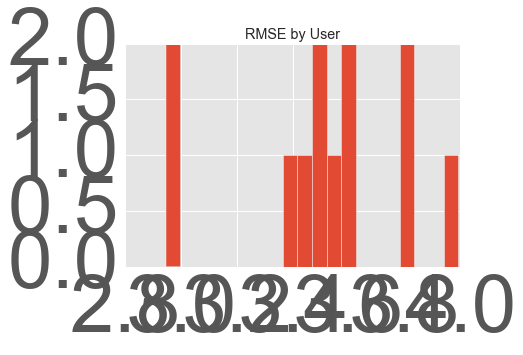

In [54]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']>50]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

In [55]:
rmse_results['precision_recall_by_user']

userId,cutoff,precision,recall,count
1,1,0.0,0.0,4
1,2,0.0,0.0,4
1,3,0.0,0.0,4
1,4,0.0,0.0,4
1,5,0.0,0.0,4
1,6,0.0,0.0,4
1,7,0.0,0.0,4
1,8,0.0,0.0,4
1,9,0.0,0.0,4
1,10,0.0,0.0,4


## Cross Validated Collaborative Filtering

In [56]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97258 observations with 671 users and 8954 items.

Data prepared in: 0.199328s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12157 / 97258 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 10                | Not Viable                               |

| 1       | 2.5               | Not Viable                               |

| 2       | 0.625             | Not Viable                               |

| 3       | 0.15625           | Not Viable                               |

| 4       | 0.0390625         | 0.873054                                 |

| 5       | 0.0195312         | 1.32495                                  |

| 6       | 0.00976562        | 1.67244                                  |

| 7       | 0.00488281        | 1.88911                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0390625         | 0.873054                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 140us        | 2.37768           | 1.10126               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 171.862ms    | 1.74733           | 1.02805               | 0.0390625   |

| 2       | 341.708ms    | 1.37899           | 0.933037              | 0.0390625   |

| 3       | 494.911ms    | 1.22809           | 0.862551              | 0.0390625   |

| 4       | 656.283ms    | 1.08848           | 0.830057              | 0.0390625   |

| 5       | 814.192ms    | 0.937048          | 0.778967              | 0.0390625   |

| 6       | 967.047ms    | 0.837662          | 0.742059              | 0.0390625   |

| 10      | 1.49s        | 0.605136          | 0.642536              | 0.0390625   |

| 11      | 1.63s        | 0.569429          | 0.624873              | 0.0390625   |

| 20      | 2.75s        | 0.387494          | 0.522643              | 0.0390625   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.313484

Final training RMSE: 0.465274


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    |       0.12      | 0.00667624622917 |
|   2    |       0.12      | 0.0135970721793  |
|   3    |       0.11      | 0.0163737377606  |
|   4    |      0.0975     | 0.0183973082056  |
|   5    |      0.094      | 0.0198622660358  |
|   6    | 0.0833333333333 | 0.0208418515119  |
|   7    | 0.0814285714286 | 0.0222609477349  |
|   8    |     0.07875     | 0.0252242938747  |
|   9    | 0.0744444444444 | 0.0287245273014  |
|   10   |      0.073      | 0.0318989489758  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.047346618150251)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  334   |   8   | 0.399962954575 |
+--------+-------+----------------+
[1 rows x 3 

In [59]:
import graphlab.aggregate as agg
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.066875,0.0871667762109,0.04860262038,0.107551323616
10,0.073,0.11122499719,0.0318989489758,0.0772079878176
36,0.0533333333333,0.0615740044555,0.0924993273906,0.140993385809
26,0.0573076923077,0.0714381016466,0.0739699960729,0.129972881977
41,0.050243902439,0.0567638061154,0.100482691729,0.143107118146
3,0.11,0.226347814952,0.0163737377606,0.0696072965733
1,0.12,0.324961536185,0.00667624622917,0.0350051659465
6,0.0833333333333,0.15,0.0208418515119,0.0711406995377
11,0.0718181818182,0.107022049169,0.0368420395454,0.106459046862
2,0.12,0.256124969497,0.0135970721793,0.0686009032646


In [60]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="movieId", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97258 observations with 671 users and 8954 items.

Data prepared in: 0.191925s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12157 / 97258 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0757314         | 1.8849                                   |

| 1       | 0.0378657         | 1.87417                                  |

| 2       | 0.0189328         | 1.92111                                  |

| 3       | 0.00946642        | 2.01451                                  |

| 4       | 0.00473321        | 2.13051                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0378657         | 1.87417                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 148us        | 2.37764           | 1.10125               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 153.536ms    | 2.1477            | 1.04458               | 0.0378657   |

| 2       | 282.143ms    | 2.01969           | 1.036                 | 0.0378657   |

| 3       | 532.141ms    | 1.9501            | 1.0258                | 0.0378657   |

| 4       | 655.485ms    | 1.93309           | 1.01475               | 0.0378657   |

| 5       | 769.686ms    | 1.92672           | 1.00917               | 0.0378657   |

| 6       | 892.051ms    | 1.92267           | 1.00631               | 0.0378657   |

| 10      | 1.38s        | 1.91526           | 0.998939              | 0.0378657   |

| 11      | 1.51s        | 1.91369           | 0.998395              | 0.0378657   |

| 20      | 2.57s        | 1.90549           | 0.994831              | 0.0378657   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.92042

Final training RMSE: 0.989695


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.2       | 0.0131786544641 |
|   2    |     0.205      | 0.0254364068435 |
|   3    | 0.196666666667 | 0.0397373222146 |
|   4    |     0.195      | 0.0515378666303 |
|   5    |     0.186      | 0.0569945377266 |
|   6    | 0.168333333333 | 0.0590496204726 |
|   7    | 0.162857142857 | 0.0621117250561 |
|   8    |      0.15      | 0.0636067192511 |
|   9    |      0.15      | 0.0714387578472 |
|   10   |     0.149      | 0.0754796269042 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0036388928798285)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  256   |   5   | 0.437474654514 |
+--------+-------+----------------+
[1 rows x 3 columns]


Per User RMSE (w

## [10 Points] Evaluate and Compare

In [61]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0287627373878 |
|   2    |     0.365      | 0.0502992255511 |
|   3    |      0.36      | 0.0715470461441 |
|   4    |      0.33      | 0.0907199336296 |
|   5    |     0.312      |  0.105341621496 |
|   6    | 0.286666666667 |  0.114775620101 |
|   7    | 0.268571428571 |  0.122780719974 |
|   8    |    0.26625     |  0.137868488726 |
|   9    |      0.26      |  0.144932939148 |
|   10   |     0.253      |  0.15445766519  |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5268356362641526)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  310   |   2   | 1.52495791659 |
+--------+-------+---------------+
[1 rows x 3 colu

In [62]:
comparisonstruct = gl.compare(test,[item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0287627373878 |
|   2    |     0.365      | 0.0502992255511 |
|   3    |      0.36      | 0.0715470461441 |
|   4    |      0.33      | 0.0907199336296 |
|   5    |     0.312      |  0.105341621496 |
|   6    | 0.286666666667 |  0.114775620101 |
|   7    | 0.268571428571 |  0.122780719974 |
|   8    |    0.26625     |  0.137868488726 |
|   9    |      0.26      |  0.144932939148 |
|   10   |     0.253      |  0.15445766519  |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.2       | 0.0131786

In [64]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

In [65]:
%%capture
params = {'user_id': 'userId', 
          'item_id': 'movieId', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=5,
        environment=None)

In [66]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 5}

In [67]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
1,movieId,0.001,50,8,4,0.25
0,movieId,0.001,50,12,4,0.25
3,movieId,0.001,25,8,8,0.5
2,movieId,0.001,25,24,8,0.1
4,movieId,0.001,25,12,8,0.1
regularization,target,user_id,training_precision@5,training_recall@5,training_rmse,validation_precision@5
0.001,rating,userId,0.450372578241,0.029251585894,0.950243443034,0.172
0.001,rating,userId,0.43695976155,0.0282564107418,0.93107925836,0.16
0.001,rating,userId,0.418479880775,0.0253346479739,1.01728825778,0.154
0.001,rating,userId,0.379433681073,0.0219863139319,0.938914658067,0.166


In [68]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : userId
 Item ID                          : movieId
 Target                           : rating
 Additional observation features  : 3
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 97258
 Number of users                  : 671
 Number of items                  : 8954
 
 Training summary
 ----------------
 Training time                    : 8.1399
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 12
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 regu

In [69]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.2       | 0.00873991003655 |
|   2    |     0.215      | 0.0278265293372  |
|   3    |      0.19      | 0.0351537608623  |
|   4    |      0.17      | 0.0383233378706  |
|   5    |      0.16      | 0.0442545279671  |
|   6    |     0.155      | 0.0483088423912  |
|   7    | 0.155714285714 | 0.0565382380491  |
|   8    |    0.16125     | 0.0640400221231  |
|   9    | 0.152222222222 | 0.0713248647925  |
|   10   |     0.147      | 0.0760333523411  |
+--------+----------------+------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.23   

## [10 Points] Visualize Results

## [20 Points] Summarize the Ramifications

# <a name="Deployment"></a>Deployment
*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
* How would your deploy your model for interested parties?
* What other data should be collected?
* How often would the model need to be updated, etc.?

In [20]:
# Kevin insert work here

# <a name="Exceptional-Work"></a>Exceptional Work
*You have free reign to provide additional analyses or combine analyses.*

1. data set with 20m+ rows
2. training and testing with two completely different data sets
3. grid search 

# <a name="References"></a>References

* https://github.com/msds7331/classification-project2/blob/master/notebooks/project2-report.ipynb
* https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
* https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
* https://grouplens.org/datasets/movielens/
* https://xkcd.com/1838/
* https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

In [24]:
# Correlation heat map matrix
# Source:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd

# Source:
# https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
data_pandas = data.to_dataframe()
corr = data_pandas.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    movie_heatmap_corr = sns.heatmap(data_pandas, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")

ValueError: Mask must have the same shape as data.

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline

dataPandas = data.to_dataframe()

# calculate the correlation matrix
corr_matrix  = dataPandas.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(180,360)) 
sns.set(font_scale=8)
sns.heatmap(upper[to_drop] , linewidths=.15, ax=ax)

ValueError: zero-size array to reduction operation minimum which has no identity

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline
#dtype={'rating':int}
filepath = '../data/ml-latest-small/ratings.csv';
ratingsP = pd.read_csv(filepath)
moviesP = pd.read_csv('../data/ml-latest-small/movies.csv')
dataP = ratingsP.merge(moviesP, on='movieId', how='left')
dataP.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [35]:
corr = dataP.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    movie_heatmap_corr = sns.heatmap(dataP, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")

ValueError: Mask must have the same shape as data.

In [31]:
dataP['rating'].dtype

dtype('float64')

In [33]:
# calculate the correlation matrix
corr_matrix  = dataP.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(180,360)) 
sns.set(font_scale=8)
sns.heatmap(upper[to_drop] , linewidths=.15, ax=ax)

ValueError: zero-size array to reduction operation minimum which has no identity